# Business Objective

This app predicts if an applicant will be approved for a credit card or not. Each time there is a hard enquiry your credit score is affected negatively. This app predict the probability of being approved without affecting your credit score. This app can be used by applicant who wants to find out if they will be approved for a credit card without affecting their credit score.

# 0. import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

C:\Users\Achilles\AppData\Local\Temp\ipykernel_9480\3341190711.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# 1. Get the Data

## 1.1 Import csv file

In [2]:
cc_data_full_data = pd.read_csv('datasets/application_record.csv')
credit_status = pd.read_csv('datasets/credit_record.csv')

In [3]:
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [4]:
credit_status.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

In [5]:
print(cc_data_full_data.shape,credit_status.shape)

(438557, 18) (1048575, 3)


## 1.2 Creating the target variable

In [6]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))


In [7]:
begin_month

MONTHS_BALANCE
ID                     
5001711              -3
5001712             -18
5001713             -21
5001714             -14
5001715             -59
...                 ...
5150482             -28
5150483             -17
5150484             -12
5150485              -1
5150487             -29

[45985 rows x 1 columns]

In [8]:
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})

In [9]:
begin_month

Account age
ID                  
5001711           -3
5001712          -18
5001713          -21
5001714          -14
5001715          -59
...              ...
5150482          -28
5150483          -17
5150484          -12
5150485           -1
5150487          -29

[45985 rows x 1 columns]

In [10]:
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
print(cc_data_full_data)

             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0               427500.0      

In [11]:
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  Account age  
0              2.0        -15.0  
1              2.0        -14.0  
2              2.0        -29.0  
3              1.0         -4.0  
4              1.0        -26.0

In [12]:
credit_status['dep_value'] = None


In [13]:
credit_status

ID  MONTHS_BALANCE STATUS dep_value
0        5001711               0      X      None
1        5001711              -1      0      None
2        5001711              -2      0      None
3        5001711              -3      0      None
4        5001712               0      C      None
...          ...             ...    ...       ...
1048570  5150487             -25      C      None
1048571  5150487             -26      C      None
1048572  5150487             -27      C      None
1048573  5150487             -28      C      None
1048574  5150487             -29      C      None

[1048575 rows x 4 columns]

In [14]:
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'

C:\Users\Achilles\AppData\Local\Temp\ipykernel_9480\1659802042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
C:\Users\Achilles\AppData\Local\Temp\ipykernel_9480\1659802042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
C:\Users\Achilles\AppData\Local\Temp\ipykernel_9480\1659802042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [15]:
credit_status

ID  MONTHS_BALANCE STATUS dep_value
0        5001711               0      X      None
1        5001711              -1      0      None
2        5001711              -2      0      None
3        5001711              -3      0      None
4        5001712               0      C      None
...          ...             ...    ...       ...
1048570  5150487             -25      C      None
1048571  5150487             -26      C      None
1048572  5150487             -27      C      None
1048573  5150487             -28      C      None
1048574  5150487             -29      C      None

[1048575 rows x 4 columns]

In [16]:
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]


In [17]:
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Civil marriage   Rented apartment      -12005          -4542   
1            Civil marriage   Rented apartment      -12005          -4542   
2                   Married  House / apartment      -21474          -1134   
3      Single / not married  House / apartment      -19110          -3051   
4      Single / not married  House / apartment      -19110          -3051   
...                     ...                ...         ...            ...   
36452               Married  House / apartment      -17348          -2420   
36453               Married  House / apartment      -12387          -1325   
36454               Married  House / apartment      -12387          -1325   
36455               Married  House / apartment      -17958           -655   
36456  Single / not married   Rented apartment       -9188          -1193   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                1           0           0             NaN   
1               1                1           0           0             NaN   
2               1                0           0           0  Security staff   
3               1                0           1           1     Sales staff   
4               1                0           1           1     Sales staff   
...           ...              ...         ...         ...             ...   
36452           1                0           0           0        Managers   
36453           1                0           1           1  Medicine staff   
36454           1                0           1           1  Medicine staff   
36455           1                0           0           0     Sales staff   
36456           1                0           0           0        Laborers   

       CNT_FAM_MEMBERS  Account age dep_value  
0                  2.0        -15.0        No  
1                  2.0        -14.0        No  
2                  2.0        -29.0        No  
3                  1.0         -4.0        No  
4                  1.0        -26.0        No  
...                ...  

In [18]:
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0


In [19]:
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

In [20]:
cc_data_full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Civil marriage   Rented apartment      -12005          -4542   
1            Civil marriage   Rented apartment      -12005          -4542   
2                   Married  House / apartment      -21474          -1134   
3      Single / not married  House / apartment      -19110          -3051   
4      Single / not married  House / apartment      -19110          -3051   
...                     ...                ...         ...            ...   
36452               Married  House / apartment      -17348          -2420   
36453               Married  House / apartment      -12387          -1325   
36454               Married  House / apartment      -12387          -1325   
36455               Married  House / apartment      -17958           -655   
36456  Single / not married   Rented apartment       -9188          -1193   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                1           0           0             NaN   
1               1                1           0           0             NaN   
2               1                0           0           0  Security staff   
3               1                0           1           1     Sales staff   
4               1                0           1           1     Sales staff   
...           ...              ...         ...         ...             ...   
36452           1                0           0           0        Managers   
36453           1                0           1           1  Medicine staff   
36454           1                0           1           1  Medicine staff   
36455           1                0           0           0     Sales staff   
36456           1                0           0           0        Laborers   

       CNT_FAM_MEMBERS  Account age Is high risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0  
...   

## 1.3 Rename features

In [21]:
# rename the features to a more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

## 1.4 Split the data into training & test datasets, creating a copy of the datasets

In [22]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df,test_size=test_size,random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [23]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [24]:
cc_train_original.shape, cc_test_original.shape

((29165, 20), (7292, 20))

In [25]:
cc_train_original.to_csv('datasets/train.csv',index=False)
cc_test_original.to_csv('datasets/test.csv',index=False)

In [26]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

# 2. Explore the Data

## 2.0 Pandas Profiling

In [27]:
profile_report = ProfileReport(cc_train_copy,explorative=True,dark_mode=True)
profile_report_file_path = Path('pandas_profile_file/credit_pred_profile.html')
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# checking if the pandas profile report file exists in the current directory
try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("pandas_profile_file/credit_pred_profile.html")

## 2.1 Quick glance at the data

In [29]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [30]:
cc_data_full_data.describe()

ID  Children count        Income           Age  \
count  3.645700e+04    36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06        0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04        0.742367  1.017892e+05   4200.549944   
min    5.008804e+06        0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06        0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06        0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06        1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06       19.000000  1.575000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       36457.000000             36457.0      36457.000000  36457.000000   
mean        59262.935568                 1.0          0.225526      0.294813   
std        137651.334859                 0.0          0.417934      0.455965   
min        -15713.000000                 1.0          0.000000      0.000000   
25%         -3153.000000                 1.0          0.000000      0.000000   
50%         -1552.000000                 1.0          0.000000      0.000000   
75%          -408.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  
count  36457.000000         36457.000000  36457.000000  
mean       0.089722             2.198453    -26.164193  
std        0.285787             0.911686     16.501854  
min        0.000000             1.000000    -60.000000  
25%        0.000000             2.000000    -39.000000  
50%        0.000000             2.000000    -24.000000  
75%        0.000000             3.000000    -12.000000  
max        1.000000            20.000000      0.000000

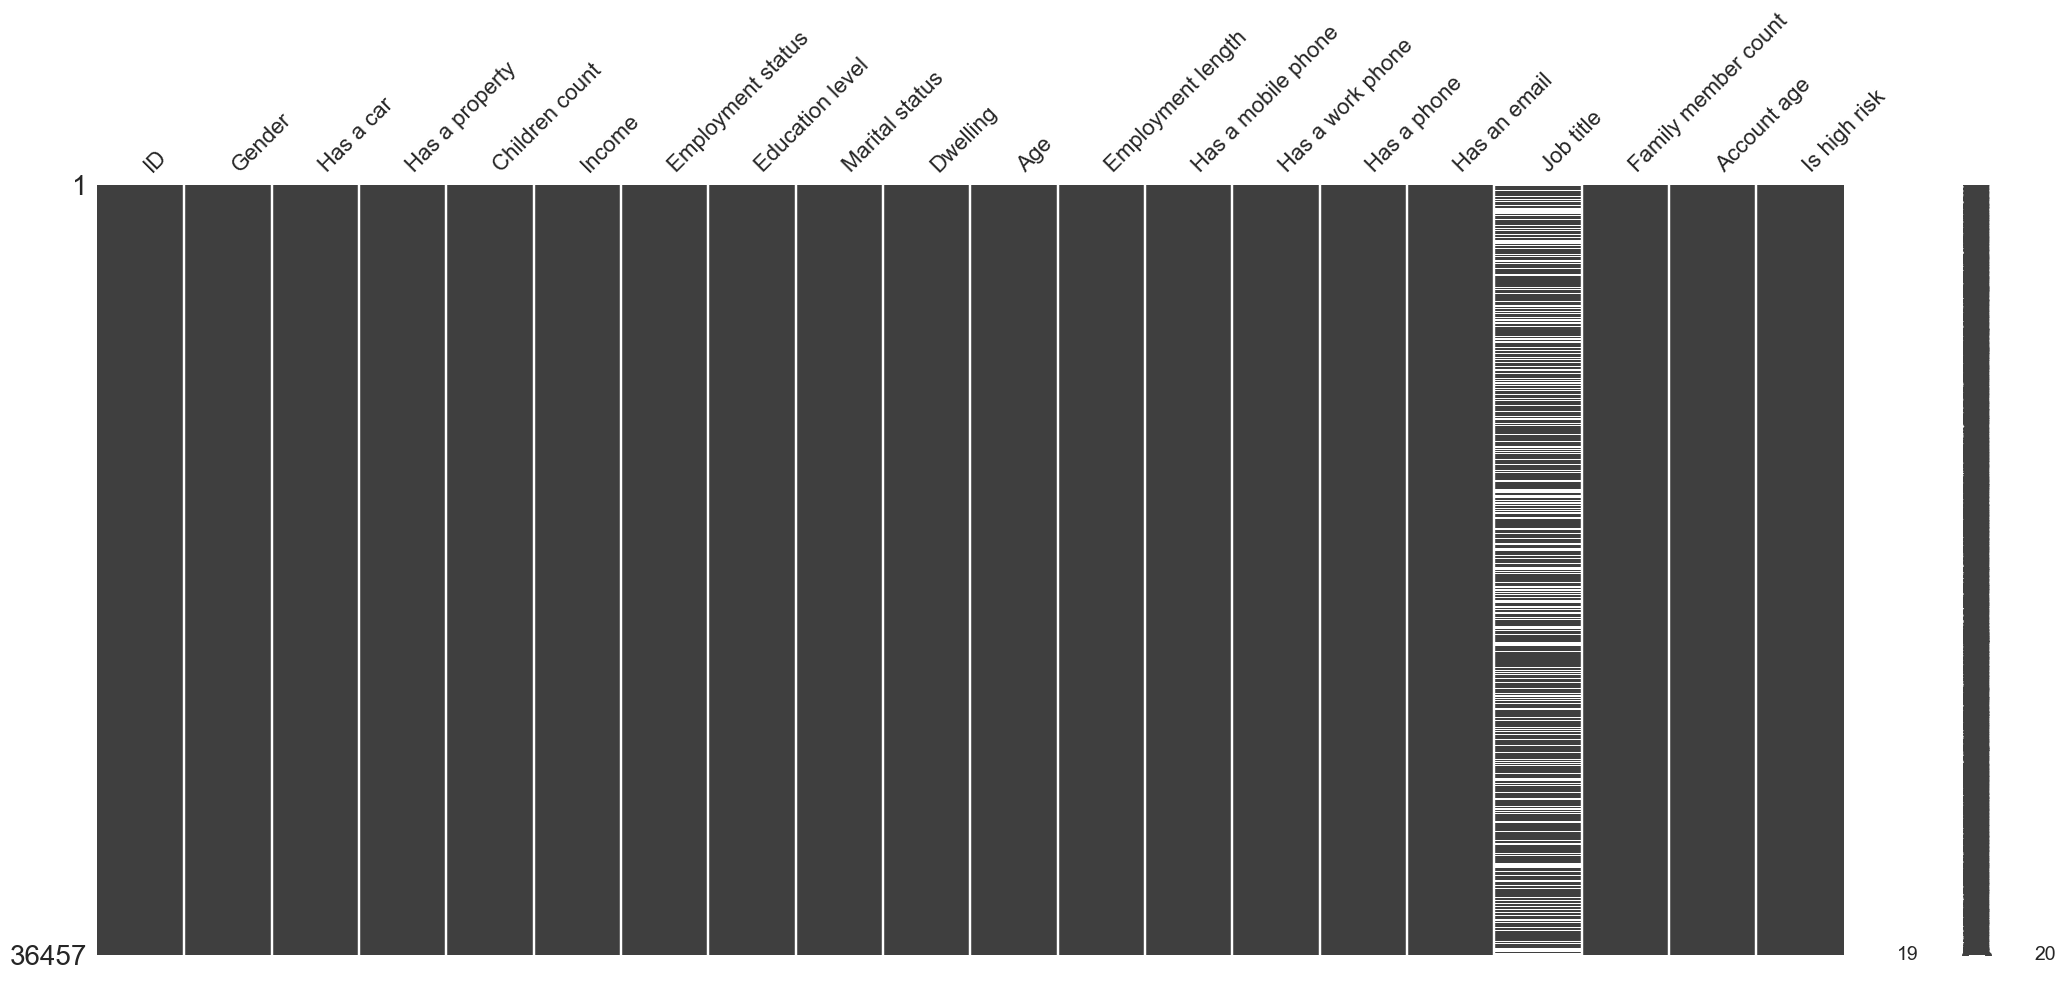

In [31]:
msno.matrix(cc_data_full_data)
plt.show()

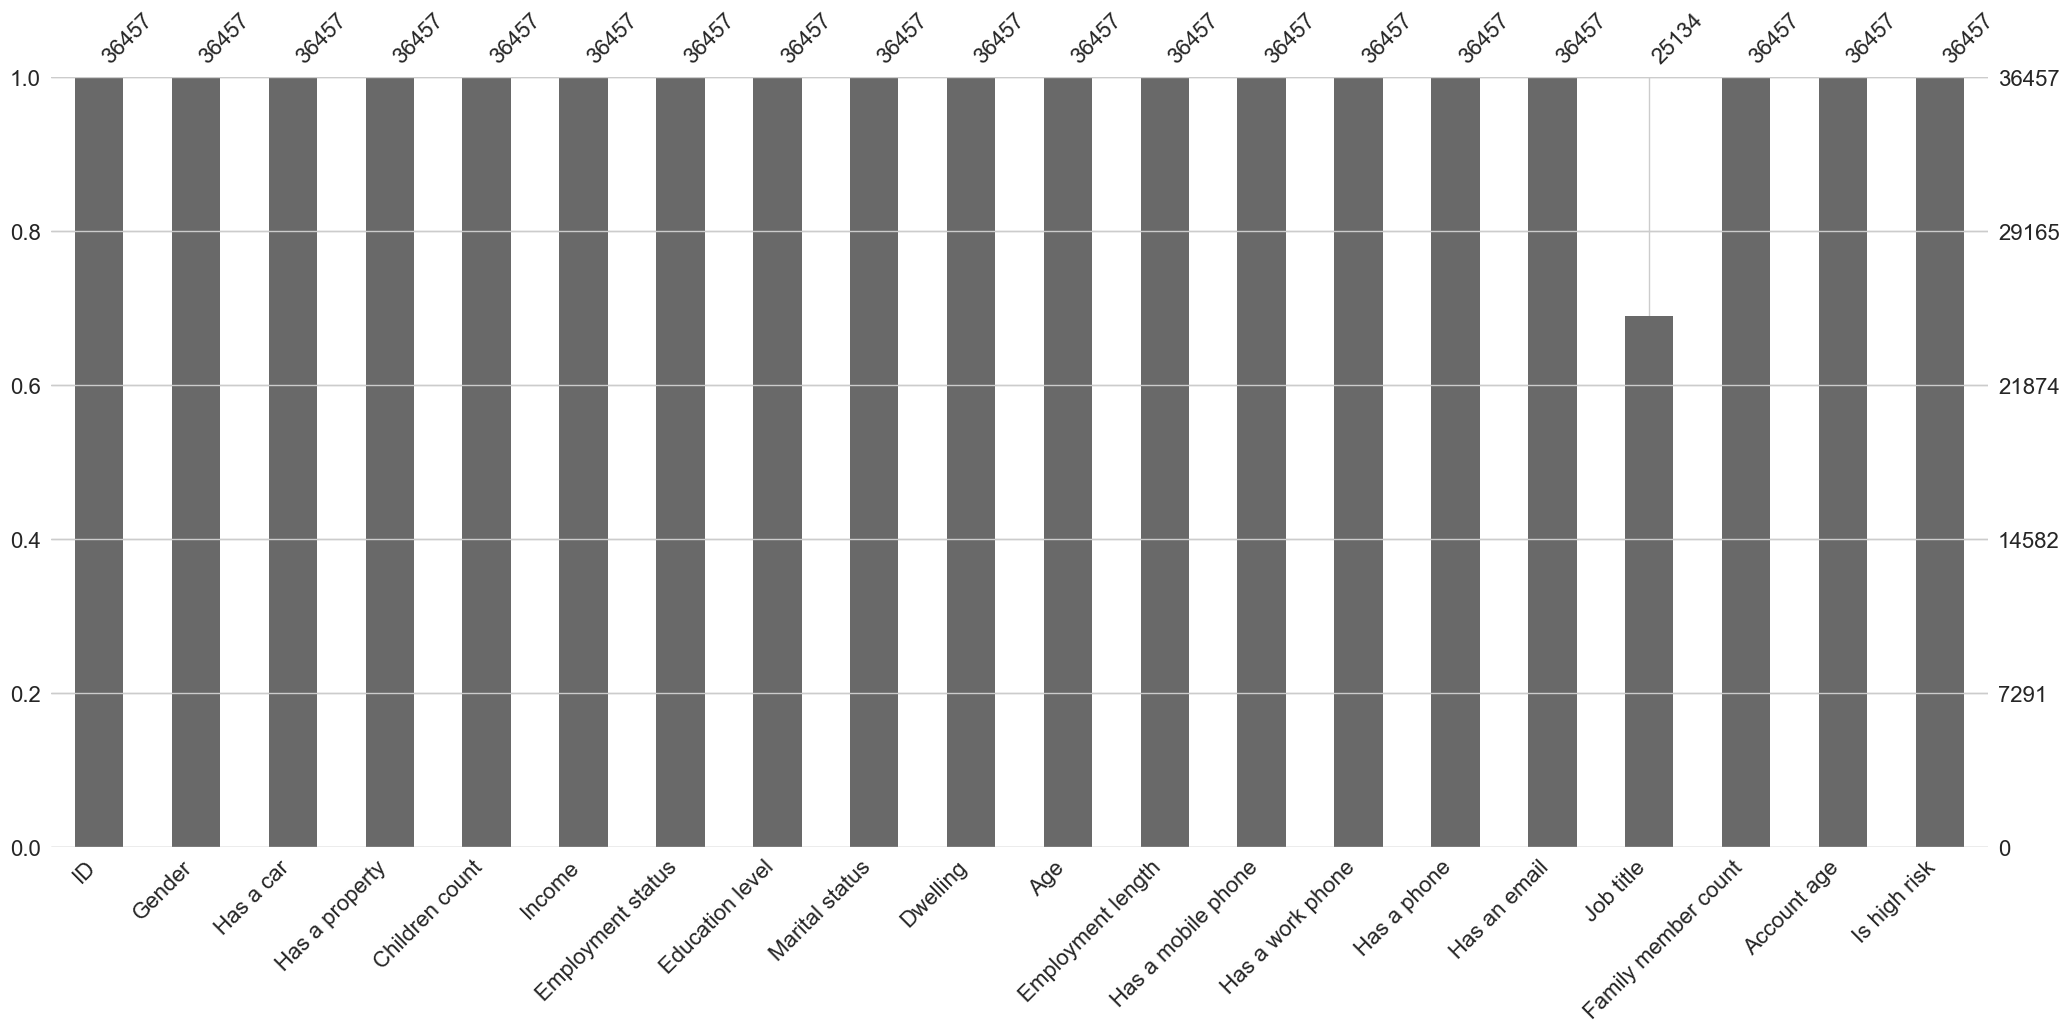

In [32]:
msno.bar(cc_data_full_data)
plt.show()

## 2.2 Functions used to explore each feature

In [43]:
# Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt,ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count','Frequency (%)']
    return ftr_value_cnt_concat

In [44]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'Age':
            # change the feature to be express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('object type:{}'.format(df[feature].dtype))
        case 'Employment length':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [45]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

In [46]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [47]:
# function to create a box plot
def create_box_plot(df,feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(2,8))
            # change the feature to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # employement length in days is a negative number so we need to change it to positive and change it to days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [48]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length':
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [49]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

In [50]:
# High risk vs low risk applicants compared on a bar plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [51]:
cc_train_copy.shape

(29165, 20)

## 2.3 Univariate analysis

### 2.3.1 Gender

In [52]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
F       19549      67.028973
M        9616      32.971027


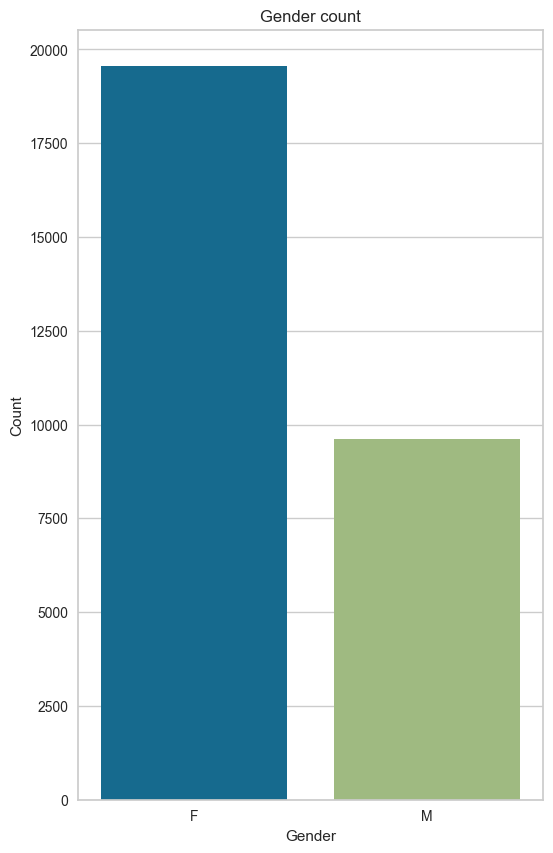

In [53]:
create_bar_plot(cc_train_copy,'Gender')

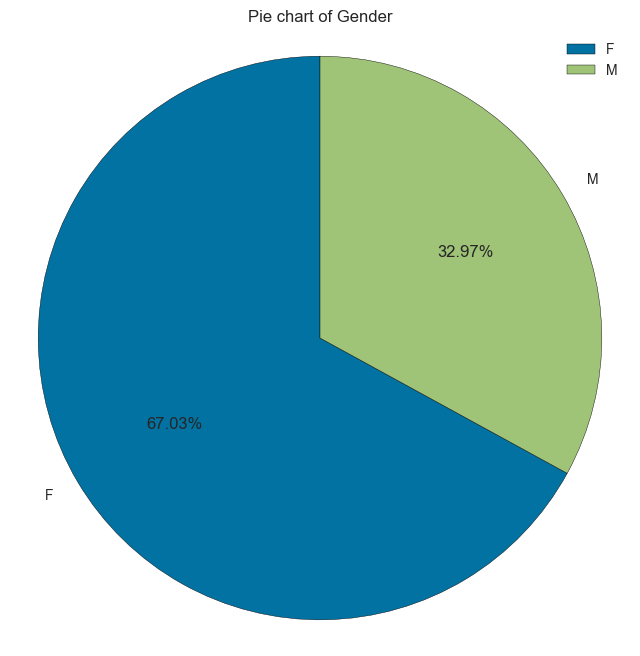

In [54]:
create_pie_plot(cc_train_copy,'Gender')

Interpretation:
- We have more female applicants than male (67% vs 32%)

### 2.3.2 Age

In [55]:
gen_info_feat(cc_train_copy,'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
object type:int64


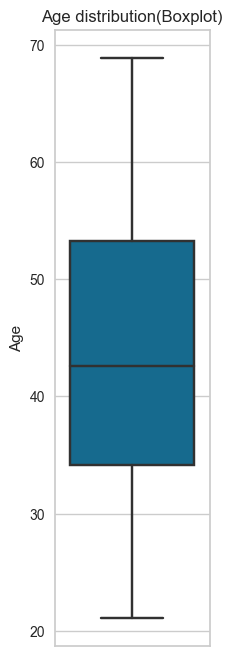

In [56]:
create_box_plot(cc_train_copy,'Age')

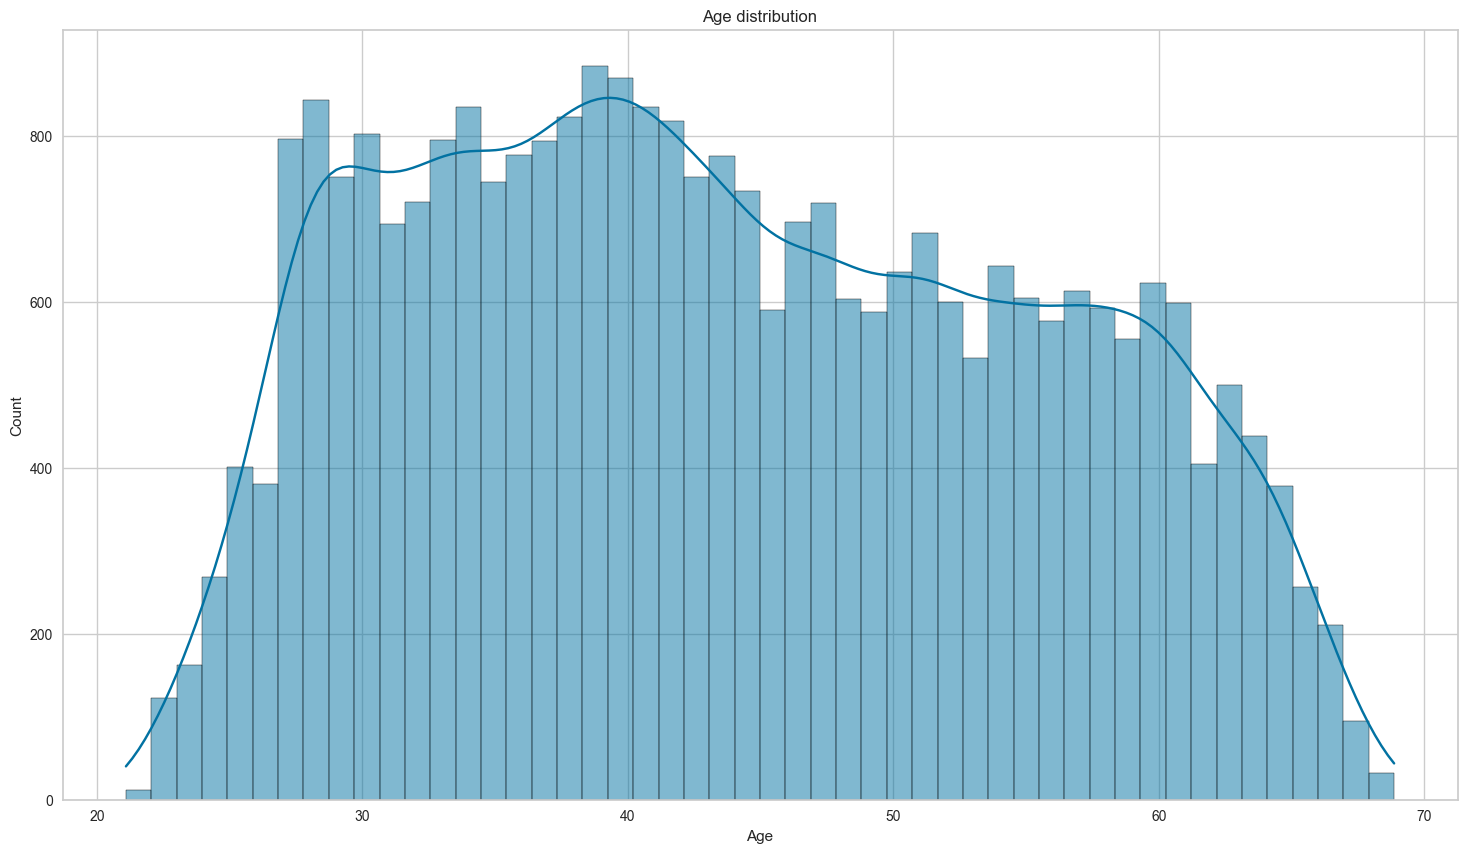

In [57]:
create_hist_plot(cc_train_copy,'Age')

* bivariate analysis with target variable

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


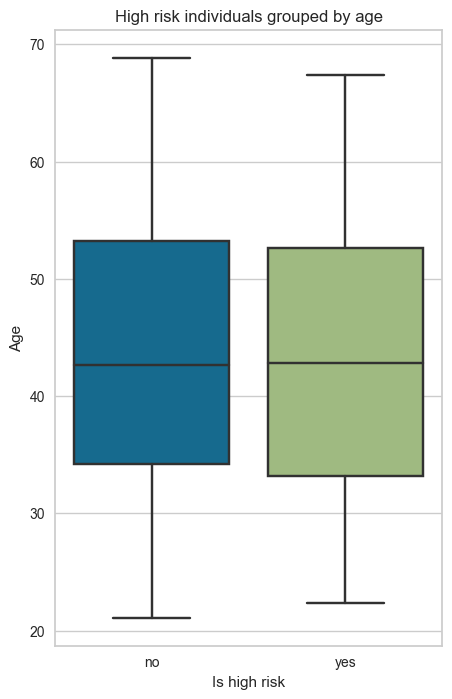

In [58]:
low_high_risk_box_plot(cc_train_copy,'Age')

Interpretation:
- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants

### 2.3.3 Matrital status